In [273]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop,Adam,Adamax,SGD
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix

**Our goal is to classify people into two income groups (more or less 50k/per year) depending on different features .**

# EDA

In [274]:
#The dataset contains information about people and their income
df = pd.read_csv(r'income_evaluation.csv')
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [275]:
df.columns

Index(['age', ' workclass', ' fnlwgt', ' education', ' education-num',
       ' marital-status', ' occupation', ' relationship', ' race', ' sex',
       ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country',
       ' income'],
      dtype='object')

In [276]:
df.shape

(32561, 15)

In [277]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1    workclass       32561 non-null  object
 2    fnlwgt          32561 non-null  int64 
 3    education       32561 non-null  object
 4    education-num   32561 non-null  int64 
 5    marital-status  32561 non-null  object
 6    occupation      32561 non-null  object
 7    relationship    32561 non-null  object
 8    race            32561 non-null  object
 9    sex             32561 non-null  object
 10   capital-gain    32561 non-null  int64 
 11   capital-loss    32561 non-null  int64 
 12   hours-per-week  32561 non-null  int64 
 13   native-country  32561 non-null  object
 14   income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [278]:
df.nunique()

age                   73
 workclass             9
 fnlwgt            21648
 education            16
 education-num        16
 marital-status        7
 occupation           15
 relationship          6
 race                  5
 sex                   2
 capital-gain        119
 capital-loss         92
 hours-per-week       94
 native-country       42
 income                2
dtype: int64

In [279]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


# Preprocessing and cleaning

In [280]:
#Checking the null values 
df.isnull().sum()

age                0
 workclass         0
 fnlwgt            0
 education         0
 education-num     0
 marital-status    0
 occupation        0
 relationship      0
 race              0
 sex               0
 capital-gain      0
 capital-loss      0
 hours-per-week    0
 native-country    0
 income            0
dtype: int64

In [281]:
#Selecting the categorical features 
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


In [282]:
#Printing the different values that can take each of the categorical features  
for i in obj_df.columns : 
  print(i," :",df[i].unique())

 workclass  : [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
 education  : [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
 marital-status  : [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
 occupation  : [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
 relationship  : [' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']
 race  : [' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']
 sex  : [' Male' ' Female']
 native-country  : [' United-State

We see that there are extra white spaces in the column names and values 

In [283]:
#Removing extra spaces from the column names 
df.columns = df.columns.str.replace(' ', '')

In [284]:
obj_df = df.select_dtypes(include=['object']).copy()

In [285]:
#Removing the extra spaces from the values 
for i in obj_df.columns : 
  df[i]=df[i].str.strip()

In [286]:
for i in obj_df.columns : 
  print(i," :",df[i].unique())

workclass  : ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
education  : ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
marital-status  : ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
occupation  : ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
relationship  : ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
race  : ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
sex  : ['Male' 'Female']
native-country  : ['United-States' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'South'
 'Puerto-Rico' 'Hondu

workclass,occupation,native-country features contain '?' values

In [287]:
(df=='?').sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [288]:
ind = df.loc[(df['workclass']=='?') | (df['occupation']=='?') | (df['native-country']=='?')].index
n_unknown = len(ind)
print('number of ? values :',n_unknown,', this represents:',np.round(((n_unknown*100)/df.shape[0]),2),'% of the rows of the dataframe')

number of ? values : 2399 , this represents: 7.37 % of the rows of the dataframe


We drop the rows that contains ? values 

In [289]:
df.drop(ind,inplace=True)

In [290]:
(df=='?').sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

# Visualization 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f261c0afd90>,
      dtype=object)

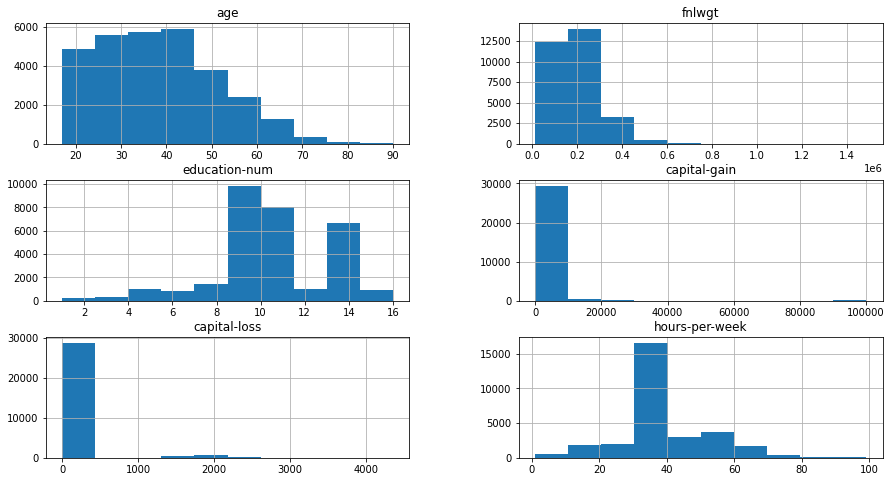

In [291]:
#Checking the distribution of the quantitative variables 
df.hist(figsize=(15,8))

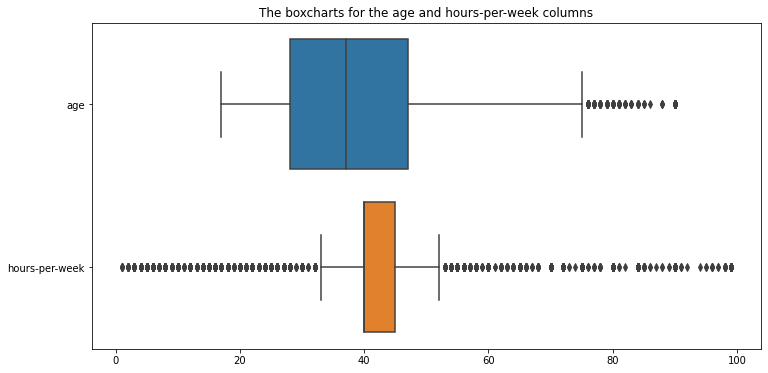

In [292]:
plt.figure(figsize=(12,6))
plt.title(f'The boxcharts for the age and hours-per-week columns')
sns.boxplot( data=df[['age', 'hours-per-week']], orient='h')
plt.show()

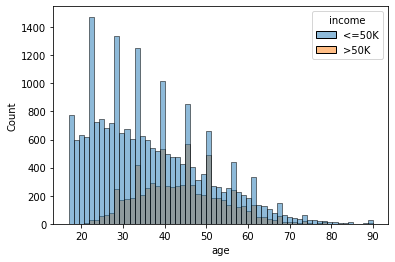

In [293]:
sns.histplot(df,x='age',hue='income')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


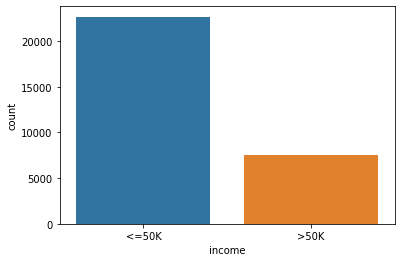

In [294]:
sns.countplot(df['income'])

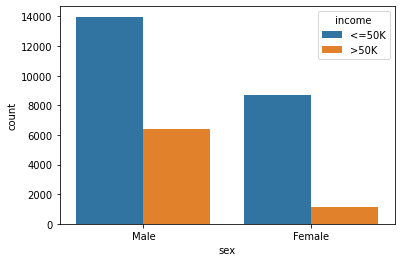

In [295]:
sns.countplot(x=df['sex'],hue=df['income'])

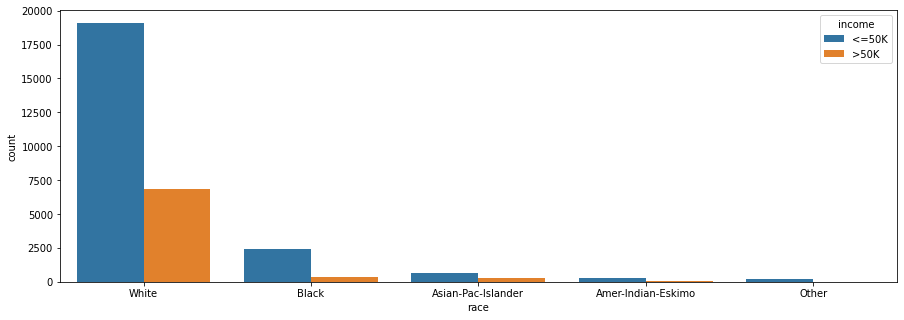

In [296]:
plt.subplots(figsize=(15,5))
sns.countplot(x=df['race'],hue=df['income'])

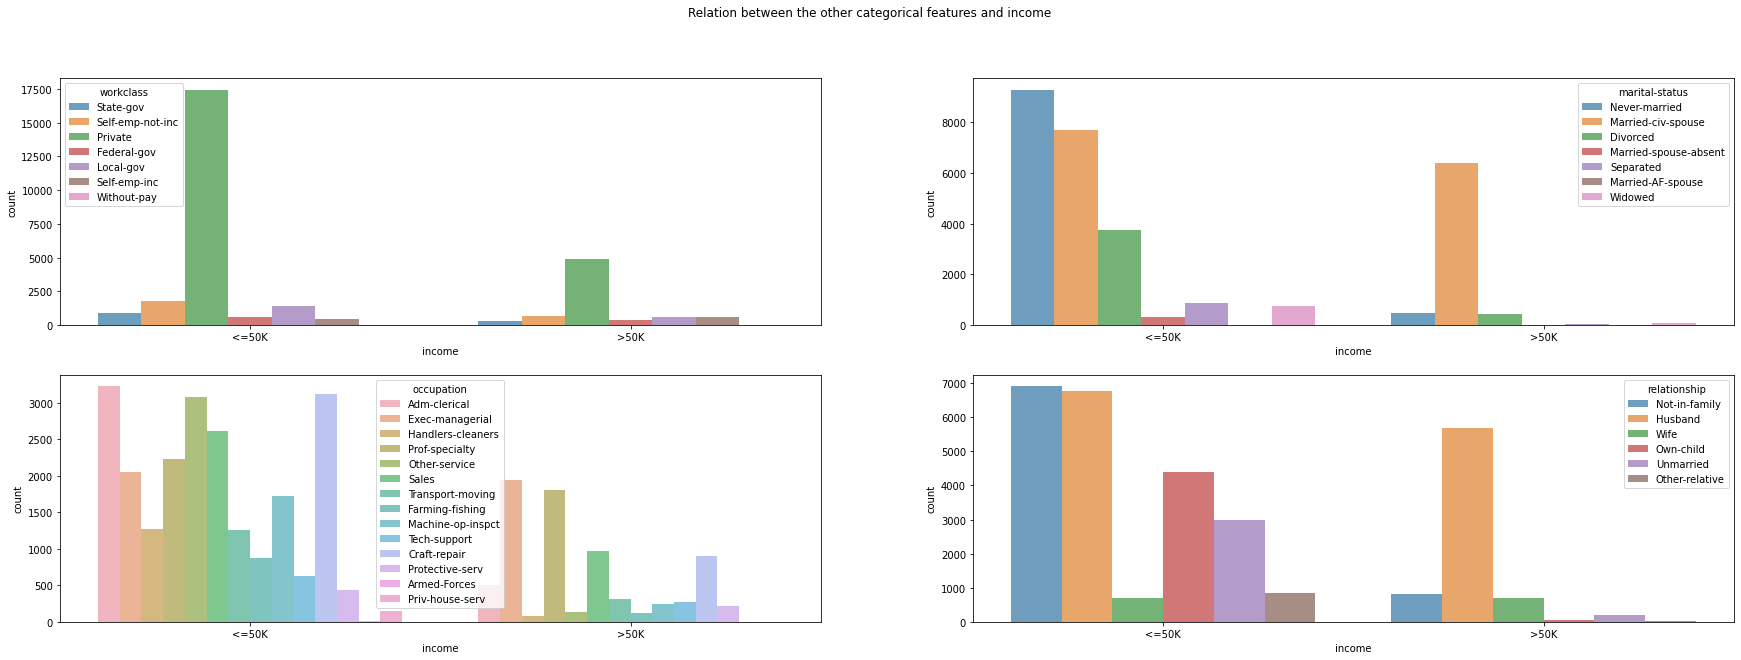

In [297]:
fig, axs = plt.subplots(2, 2, figsize=(30,10))
axs = axs.flatten()
fig.suptitle('Relation between the other categorical features and income')

categorical = ['workclass', 'marital-status','occupation','relationship']
for ax, i in enumerate(categorical):
    sns.countplot(x='income', alpha=0.7, hue=i, data=df, ax=axs[ax])

## Converting categorical features into numerical

In [298]:
#We use the ordinal encoder to transform the categorical features into numerical
ord_enc = OrdinalEncoder()
df_encod = df
for i in obj_df.columns : 
  df_encod[i] = ord_enc.fit_transform(df_encod[[i]])

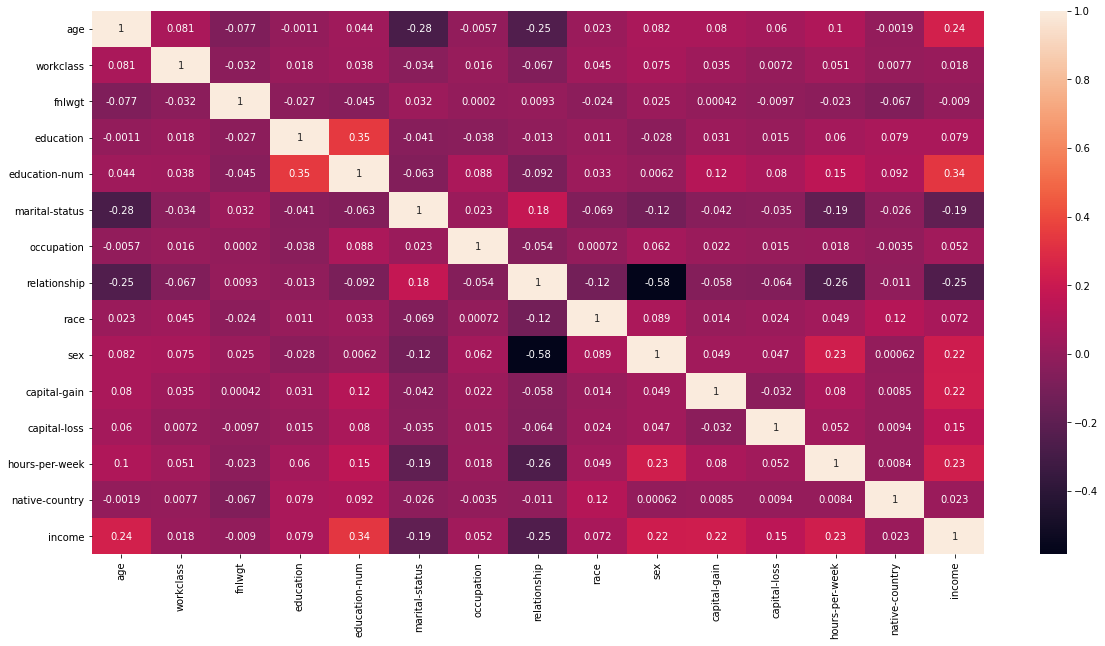

In [299]:
#We plot the correlation matrix to extract the features that are the most correlated with the target 
plt.subplots(figsize=(20,10))
corr_mat = df_encod.corr()
sns.heatmap(corr_mat,annot=True)

The features that are the most correlated with income are : <br>
'education-num' <br>
'relationship' <br>
'age' <br>
'hours-per-week' <br>
'sex' <br>
'marital-status' <br>
'capital-gain'

In [300]:
#Features selection 
X = df_encod[['age','education-num','relationship','sex','hours-per-week','marital-status','capital-gain']]
Y = df_encod['income']

### Normalize

In [301]:
#Normalizing the feature
X = normalize(X)

In [302]:
#Splitting the dataset into training and testing 
x_train , x_test , y_train , y_test = train_test_split(X,Y,test_size=0.2)

In [306]:
#Building the model
model= Sequential([
   Dense(128,input_dim=x_train.shape[1],activation='relu'),    
   Dense(30,activation='relu'),
   Dense(1,activation='sigmoid')
   ])
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 128)               1024      
_________________________________________________________________
dense_157 (Dense)            (None, 30)                3870      
_________________________________________________________________
dense_158 (Dense)            (None, 1)                 31        
Total params: 4,925
Trainable params: 4,925
Non-trainable params: 0
_________________________________________________________________


In [307]:
batch_size = 80
epochs = 40 

model.compile(loss = "binary_crossentropy", optimizer = Adam(),metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    verbose=1
                    )

Epoch 1/40
242/242 [==============================] - 1s 2ms/step - loss: 0.5337 - binary_accuracy: 0.7714 - val_loss: 0.5346 - val_binary_accuracy: 0.7605
Epoch 2/40
242/242 [==============================] - 0s 2ms/step - loss: 0.4849 - binary_accuracy: 0.7771 - val_loss: 0.4866 - val_binary_accuracy: 0.7609
Epoch 3/40
242/242 [==============================] - 0s 2ms/step - loss: 0.4571 - binary_accuracy: 0.7785 - val_loss: 0.4698 - val_binary_accuracy: 0.7605
Epoch 4/40
242/242 [==============================] - 1s 2ms/step - loss: 0.4481 - binary_accuracy: 0.7795 - val_loss: 0.4616 - val_binary_accuracy: 0.7642
Epoch 5/40
242/242 [==============================] - 1s 2ms/step - loss: 0.4403 - binary_accuracy: 0.7844 - val_loss: 0.4573 - val_binary_accuracy: 0.7661
Epoch 6/40
242/242 [==============================] - 0s 2ms/step - loss: 0.4335 - binary_accuracy: 0.7893 - val_loss: 0.4449 - val_binary_accuracy: 0.7758
Epoch 7/40
242/242 [==============================] - 0s 2ms/ste

In [308]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', np.round(score[1],2))

Test accuracy: 0.84


In [309]:
from sklearn import metrics
y_pred = model.predict(x_test) #Testing our model 
y_pred = np.round(y_pred)

Confusion matrix

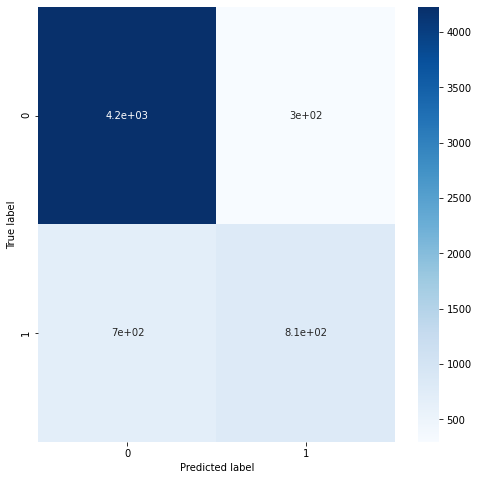

In [310]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()